# Analysis of biodiversity in R with `vegan`

This tutorial shows how to analyze general biodiversity data sets, which consist of data on the occurrence of a species at different sites.

It is assumed basic knowledge of R and multivariate statistics.

In [1]:
# install.packages("vegan")
library(vegan)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3


## Data

We will use one of `vegan`'s native data sets (`data(package = "vegan")`):

In [2]:
data(dune) # Vegetation and Environment in Dutch Dune Meadows

# explore interal structure of data
str(dune) 

'data.frame':	20 obs. of  30 variables:
 $ Achimill: num  1 3 0 0 2 2 2 0 0 4 ...
 $ Agrostol: num  0 0 4 8 0 0 0 4 3 0 ...
 $ Airaprae: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Alopgeni: num  0 2 7 2 0 0 0 5 3 0 ...
 $ Anthodor: num  0 0 0 0 4 3 2 0 0 4 ...
 $ Bellpere: num  0 3 2 2 2 0 0 0 0 2 ...
 $ Bromhord: num  0 4 0 3 2 0 2 0 0 4 ...
 $ Chenalbu: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Cirsarve: num  0 0 0 2 0 0 0 0 0 0 ...
 $ Comapalu: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Eleopalu: num  0 0 0 0 0 0 0 4 0 0 ...
 $ Elymrepe: num  4 4 4 4 4 0 0 0 6 0 ...
 $ Empenigr: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Hyporadi: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Juncarti: num  0 0 0 0 0 0 0 4 4 0 ...
 $ Juncbufo: num  0 0 0 0 0 0 2 0 4 0 ...
 $ Lolipere: num  7 5 6 5 2 6 6 4 2 6 ...
 $ Planlanc: num  0 0 0 0 5 5 5 0 0 3 ...
 $ Poaprat : num  4 4 5 4 2 3 4 4 4 4 ...
 $ Poatriv : num  2 7 6 5 6 4 5 4 5 4 ...
 $ Ranuflam: num  0 0 0 0 0 0 0 2 0 0 ...
 $ Rumeacet: num  0 0 0 0 5 6 3 0 2 0 ...
 $ Sagiproc: num  0 0 0 5 0 0 0 2 2 

This a data frame consisting of 20 sites (observations) and 30 plant species (variables). 

**The input data frame for `vegan` must be structured with the species as column headers and the localities as rows**.

## Diversity indices 

The most common diversity measures are built as functions into `vegan`. We can use them to calculate indices of diversity for each site. For example:

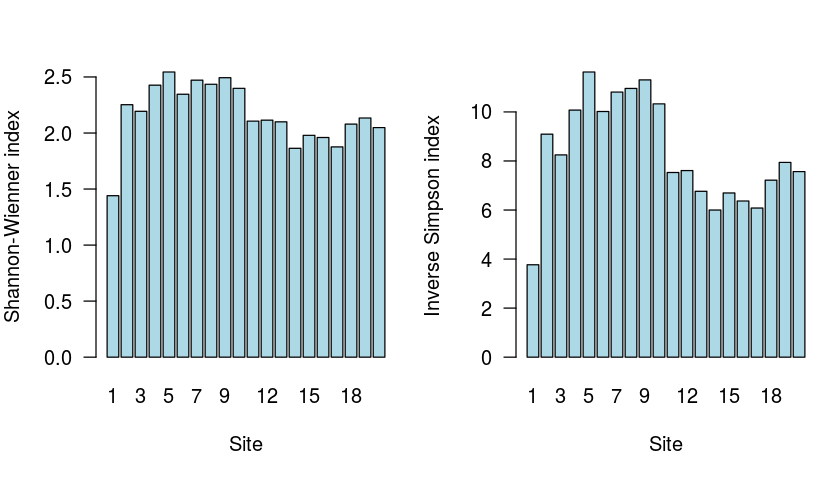

In [3]:
# species richness: total number of species in a community
richness <- specnumber(dune)

# Shannon-Wienner index
shannon <- diversity(dune, index = "shannon") # is the default
# highest when all species are equally abundant, in [0, +inf)

# Simpson ’s index
inv_simpson <- diversity(dune, index = "invsimpson")
# weighted towards most common species (ignores rare species)
# highest when all species are equally abundant, lowest when community is dominated by few species

# the results can be visualized as bar plots
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5,4,3,1))
barplot(shannon, xlab="Site", ylab="Shannon-Wienner index", col="lightblue", las=1)
barplot(inv_simpson, xlab="Site", ylab="Inverse Simpson index", col="lightblue", las=1)

## (Dis)Similarity indices

The function `vegdist` has built-in many statistics used to quantify the compositional dissimilarity of sites. 

In [4]:
# For example, Bray-Curtis dissimilarity (which is the default)
bray <- vegdist(dune, method="bray") 

The function `designdist` lets us define our own distance measure:

In [5]:
# like another version of Jaccard's coefficient
jaccard <- designdist(dune, 
                      method = "a/(a+b+c)", 
                      # a is the number of shared species, 
                      # b and c are the numbers of species occurring in only one of the sites 
                      # and d is the number of species that occur on neither of the sites
                      terms = "binary", # for presence-absence
                      abcd = TRUE) # use 2x2 contingency table notation for binary data

Some indices require relative abundance, so we need to calculate the total abundance of each species (columns) in each site (rows). We could do this manually, but `vegan` has a function to calculate different standardization methods:

In [7]:
# method "total" standardizes each occurrence by margin total
dune_std <- decostand(dune, method = "total")

# we can check by looking at the total abundances
# apply(dune_std, 1, sum)

Now, we can compute other dissimilarity measures:

In [8]:
# for example, the percentage of shared species
percent_similarity <- designdist(dune_std, 
                                 method = "J", # for shared quantity
                                 terms = "minimum") # J = sum(pmin(x,y))

## Species accumulation and rarefaction curves 

To asses the completeness of the data we can plot the cumulative number of species recorded as a function of the cumulative search effort, this is called species accumulation curve.

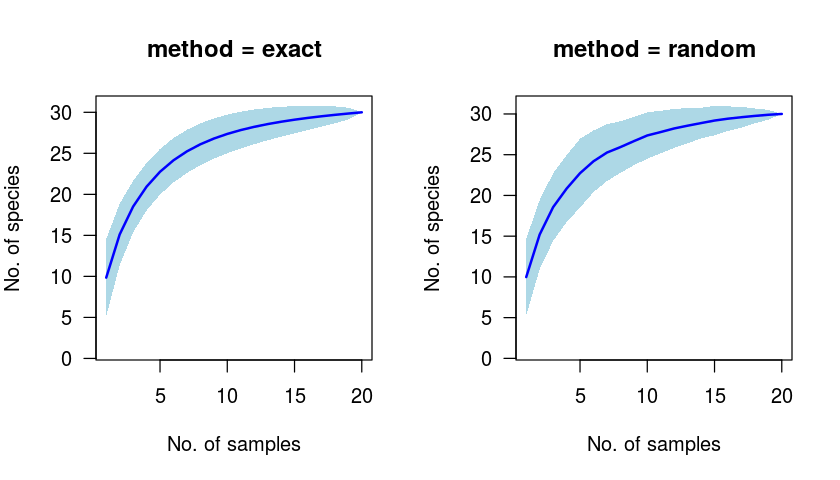

In [9]:
# The built-in function is `specaccum`
curve1 <- specaccum(dune)
# method "exact" (default) finds the expected (mean) species richness

# method "random" adds sites in a random order 
curve2 <- specaccum(dune, method = "random")

options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5, 4, 4, 2))
plot(curve1, main = "method = exact", 
     xlab = "No. of samples", ylab = "No. of species", 
     ci.type="poly", col="blue", lwd=2, ci.lty=0, ci.col="lightblue", las=1)
plot(curve2, main = "method = random", 
     xlab = "No. of samples", ylab = "No. of species", 
     ci.type="poly", col="blue", lwd=2, ci.lty=0, ci.col="lightblue", las=1)

The species richness can also be evaluated according to the species richness for a given number of samples, a.k.a. rarefaction curves.

In [10]:
# we need a sample size, usually something between the minimum and the total community size.
# let's use the minimum
raremin <- min(apply(dune, 1, sum)) 

# we use the function `rarefy` to get the expected species richness in a random subsample 
# of size raremin 
dune_rarefied <- rarefy(dune, sample = raremin)

# plot rarefaction
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5,4,2,1))
plot(richness, dune_rarefied, col = "blue", pch = 19, las=1,
     xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")
abline(0, 1)

# or we can just use the `rarecurve` function, to plot the rarefaction curve for each site
rarecurve(dune, col = "blue", 
          cex = 0.6, lwd=1.5)

## Multivariate analysis

### Hierarchical clustering

Communities can be clustered according to the dissimilarity distances we calculated before:

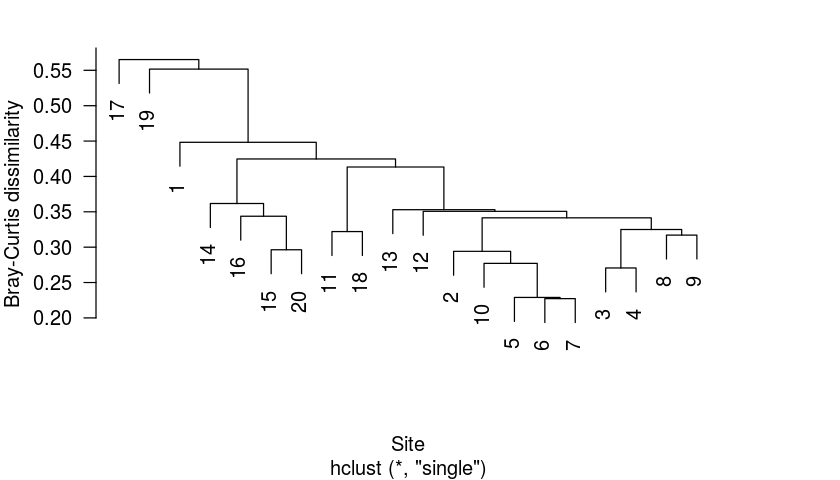

In [11]:
# for example, using single-linkage algorithm
dune_bray_clust <- hclust(bray, method = "single")

# plot cluster diagram
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,1), mar = c(5,4,2,5))

plot(dune_bray_clust, xlab="Site", ylab = "Bray-Curtis dissimilarity", main = "", las=1)

### Non-Metric Multidimensional Scaling (NMDS)

We can compare the species composition of each site using rank orders, for this similarity distances are displayed according to the relative position of the sites.

In [22]:
# the function `metaMDS` standardizes data and checks the robustness of the solution
dune_mds <- metaMDS(dune, dist = "bray")

Run 0 stress 0.1192678 
Run 1 stress 0.1183186 
... New best solution
... Procrustes: rmse 0.0202689  max resid 0.0649499 
Run 2 stress 0.1192679 
Run 3 stress 0.1183186 
... Procrustes: rmse 5.943884e-05  max resid 0.0001501014 
... Similar to previous best
Run 4 stress 0.1192689 
Run 5 stress 0.1183186 
... Procrustes: rmse 5.319461e-05  max resid 0.0001520588 
... Similar to previous best
Run 6 stress 0.1183186 
... Procrustes: rmse 2.266677e-05  max resid 6.949547e-05 
... Similar to previous best
Run 7 stress 0.1192681 
Run 8 stress 0.1192678 
Run 9 stress 0.1192679 
Run 10 stress 0.1192681 
Run 11 stress 0.1192681 
Run 12 stress 0.1183189 
... Procrustes: rmse 9.480655e-05  max resid 0.0002403989 
... Similar to previous best
Run 13 stress 0.1192678 
Run 14 stress 0.1183186 
... New best solution
... Procrustes: rmse 4.875428e-06  max resid 1.469532e-05 
... Similar to previous best
Run 15 stress 0.1183186 
... New best solution
... Procrustes: rmse 4.526606e-06  max resid 1.5661

NMDS is an iterative method. We need a measure of disagreement between data and model, in this case is called stress and the solution tries to minimize it.

In [23]:
dune_mds$stress
# stress > 0.05 provides an excellent representation in reduced dimensions
# stress> 0.1 is great
# stress>0.2 is good/ok
# stress > 0.3 provides a poor representation

[1] 0.1183186

Goodness of fit is also assessed with a stress plot (or Shepard plot), which shows scatter around the model solution against the original dissimilarities of the data. 

The result of the NMDS orders the sites and species in a multidimensional space.

In [24]:
# set graphical parameters
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5,4,2,1))

# stress plot 
stressplot(dune_mds, las=1)

# the default plot, with sites as text is retrieved by
# ordiplot(dune_mds, display = "sites", type = "text")
# but can also be customized as
pl <- ordiplot(dune_mds, type = "none", las=1)
points(pl, "sites", pch=21)
text(pl, "species", col="blue", cex=0.9)

# can also plot with species labels, optimizing overlapping
# ordipointlabel(dune_mds)

It is also possible to include environmental features in the NMDS. For `dune`, this metadata is stored in the `dune.env` data set. In this case it's interesting to look at the type of management for each site: BF (Biological farming), HF (Hobby farming), NM (Nature Conservation Management), and SF (Standard Farming).

In [25]:
# load metadata for dune
data(dune.env)

# set plotting area
options(repr.plot.width=5, repr.plot.height=5)
par(mfrow = c(1,1), mar = c(5,7,2,1))

dune_mds_fig <- ordiplot(dune_mds, type = "none", las=1)
# plot the samples and colour by habitat
points(dune_mds_fig, "sites", pch = 19, col = "green", select = dune.env$Management == "BF")
points(dune_mds_fig, "sites", pch = 19, col = "blue", select = dune.env$Management == "HF")
points(dune_mds_fig, "sites", pch = 19, col = "purple", select = dune.env$Management == "NM")
points(dune_mds_fig, "sites", pch = 19, col = "red", select = dune.env$Management == "SF")
# add confidence ellipses around habitat types
ordiellipse(dune_mds, dune.env$Management, conf = 0.95, label = TRUE)
# we can even overlay the cluster results we calculated earlier
# ordicluster(dune_mds, dune_bray_clust, col = "gray")

Changes in the environmental gradient (for a continuous variable) or in the abundance of one species can be visualized as contour plots.


Family: gaussian 
Link function: identity 

Formula:
y ~ s(x1, x2, k = 10, bs = "tp", fx = FALSE)

Estimated degrees of freedom:
1.59  total = 2.59 

REML score: 41.58728     

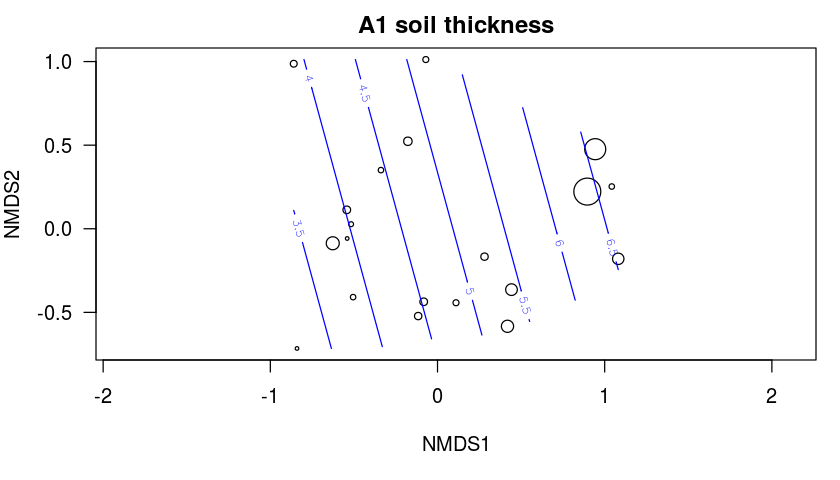

In [30]:
# For example, the thickness of soil in the A1 horizon (`dune.env$A1`)
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,1), mar = c(5,4,2,1))

ordisurf(dune_mds ~ A1, dune.env, bubble = TRUE, main = "A1 soil thickness", 
         cex = 3, las=1, col="blue")


Family: gaussian 
Link function: identity 

Formula:
y ~ s(x1, x2, k = 10, bs = "tp", fx = FALSE)

Estimated degrees of freedom:
4.97  total = 5.97 

REML score: 42.60497     

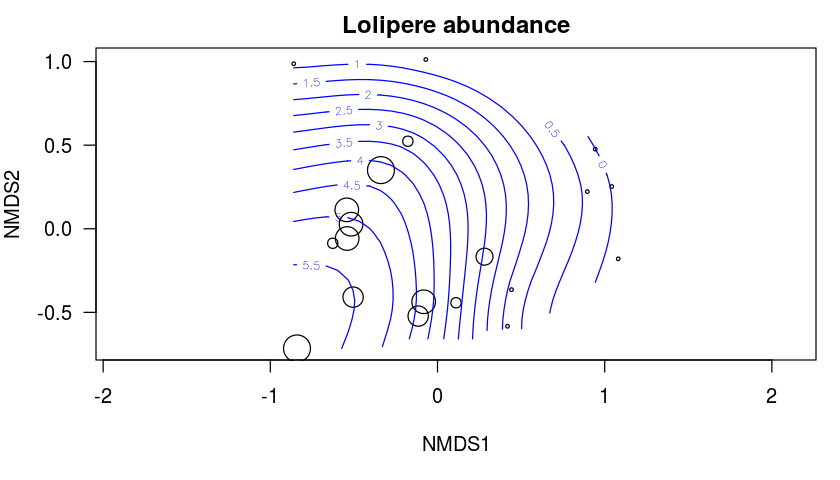

In [28]:
# or the abundance of *Lolipere* (`dune$Lolipere`)
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,1), mar = c(5,4,2,1))

ordisurf(dune_mds, dune[, "Lolipere"], bubble = TRUE, main = "Lolipere abundance", 
         cex = 3, las=1, col="blue")

The results can be improved by making a canonical correspondance analysis, which relates the species assembly to environmental variables:

In [17]:
dune_mod <- cca(dune ~ Management, dune.env)

# see output
# summary(dune_mod)

But these results are best visualized, there are many options:

In [18]:
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5,4,2,1))

# use ordispider to connect WA and LC scores
plot(dune_mod, dis=c("wa","lc"), type="p", las=1)
ordispider(dune_mod)

# or add Bray-Curtis dissimilarity cluster
plot(dune_mod, type = "p", display="sites", las=1)
ordicluster(dune_mod, dune_bray_clust, prune=3, col = cutree(dune_bray_clust, 4))

In [19]:
options(repr.plot.width=7, repr.plot.height=4)
par(mfrow = c(1,2), mar = c(5,4,2,1))

# plot ellipsoid hulls
plot(dune_mod, type = "n", las=1)
dune_plot <- with(dune.env, ordihull(dune_mod, Management,
                              scaling = "symmetric", col = 1:4,
                              draw="polygon", label =TRUE))
with(dune.env, ordiellipse(dune_mod, Management, scaling = "symmetric",
                           kind = "ehull", col = 1:4, lwd=3))

# or add confidence ellipse: location of the class centroids
plot(dune_mod, type="n", display = "sites", las=1)

with(dune.env, text(dune_mod, display="sites", labels = as.character(Management),
                    col=as.numeric(Management)))

dune_plot2 <- with(dune.env, ordiellipse(dune_mod, Management, kind="se", conf=0.95, lwd=2,
                                 draw = "polygon", col=1:4, border=1:4,
                                 alpha=63))

# and add confidence bars
with(dune.env, ordibar(dune_mod, Management, kind="se", conf=0.95, lwd=2, col=1:4,
                       label=TRUE))

In [20]:
# see summaries with centres and areas of the hulls
summary(dune_plot)

summary(dune_plot2)

BF        HF         NM         SF        
CCA1 0.2917476 0.36826105 -1.3505642  0.2762936
CCA2 0.8632208 0.09419919  0.2681515 -0.8139398
Area 0.1951715 0.59943363  1.7398193  1.0144372

BF        HF        NM          SF        
CCA1 0.4312652 0.5583211 -1.87848340  0.5601499
CCA2 1.3273917 0.6373120 -0.05503211 -1.3859924
Area 1.4559842 1.3806668  2.73667419  1.5559135

## References

Oksanen, J., Blanchet, F.G., Kindt, R., Legendre, P., Minchin, P.R., O’hara, R.B., Simpson, G.L., Solymos, P., Stevens, M.H.H., Wagner, H. and Oksanen, M.J., 2018. Package ‘vegan’. Community ecology package, version 2.5-3. Available at https://cran.r-project.org/web/packages/vegan/vegan.pdf